# YouTube Subtitle Analysis
Here we analyze subtitles fetched from YouTube.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [19]:
%connect_info

{
  "shell_port": 40667,
  "iopub_port": 56235,
  "stdin_port": 50717,
  "control_port": 42523,
  "hb_port": 52907,
  "ip": "127.0.0.1",
  "key": "4dd55898-db51ae3a811128ab764f6a89",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-7805daa5-398f-4bfd-9cfb-00d1c0e38bfe.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [20]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [21]:
import sqlite3
import pandas as pd
import isodate
import pytz

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)

cest = pytz.timezone("Europe/Berlin")

data['publishedAt'] = pd.to_datetime(data['publishedAt']).dt.tz_convert(cest)
data['updated'] = pd.to_datetime(data['updated']).dt.tz_convert(cest)

data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')

data['tags'] = data['tags'].apply(lambda t: t.split("'")[1::2])
data['duration'] = data['duration'].apply(lambda t: isodate.parse_duration(t).total_seconds())
data['faction'] = data['faction'].apply(lambda x: x.lower() == 'true')
data['caption'] = data['caption'].apply(lambda x: x.lower() == 'true')

no_subs_ids = data['subtitle'].apply(lambda x: len(x) <= 10)
data.loc[no_subs_ids, 'subtitle'] = data.loc[no_subs_ids, 'description']
data.loc[no_subs_ids, 'capByDesc'] = True
data.loc[~no_subs_ids, 'capByDesc'] = False

data.set_index('videoId', inplace=True)

## Variables
### Dates and periods

In [22]:
from datetime import datetime as time, timedelta

bt_election = cest.localize(time.fromisoformat('2017-09-24')).replace(hour=8)
eu_election = cest.localize(time.fromisoformat('2019-05-26')).replace(hour=8)

bt_start = bt_election - timedelta(days=83)
eu_start = eu_election - timedelta(days=83)
bt_end = bt_election + timedelta(days=84)
eu_end = eu_election + timedelta(days=84)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

pre_bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_election)
pre_eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_election)
pos_bt_period = (bt_election <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
pos_eu_period = (eu_election <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

corpus = data[bt_period|eu_period]
bt_corpus = data[bt_period]
eu_corpus = data[eu_period]

campaign_corpus = data[pre_bt_period|pre_eu_period]
bt_campaign_corpus = data[pre_bt_period]
eu_campaign_corpus = data[pre_eu_period]

### Parties, elections and states

In [23]:
parties = {'union': 'Union',
         'spd': 'SPD',
         'afd': 'AfD',
         'fdp': 'FDP',
         'linke': 'Die Linke',
         'grüne': 'Die Grünen'}
elections = ['bt', 'eu']
new_states = ['BB', 'MV', 'SN', 'ST', 'TH']
old_states = ['BW', 'BY', 'HB', 'HH', 'HE', 'NI', 'NW', 'RP', 'SL', 'SH']

### Colors

In [24]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Methods

### Cleaning and tokenization

0. (Optional, default off) Replace numbers with nothing
1. Replaces `<URL>` with single space
1. Replaces `_` with space
1. Replaces `<Non-Ascii except ÄäÜüÖöß>` with nothing
2. Replaces `<letter>-<letter>` with `<letter><letter>`
2. Replaces `<letter>*<letter>` with `<letter><letter>`
3. Replaces `<non-words>-<newline><non-words>` with nothing
4. Replaces `<non-words><newline><non-words>` with single space
5. Replaces `<non-words>` with single space

In [25]:
import re

def clean_and_tokenize(text, remove_numbers=False, min_len=None):
    if remove_numbers:
        replaced = re.sub(r'\d+', ' ', text)
    else:
        replaced = text
        
    replaced = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', replaced)
    replaced = replaced.replace('_', ' ')
    replaced = ''.join([i if ord(i) < 128 or ord(i) in [228,196,246,214,252,220,223] else '' for i in replaced])
    replaced = re.sub(r'(\w)-(\w)', r'\1\2', replaced)
    replaced = re.sub(r'(\w)\*(\w)', r'\1\2', replaced)
    replaced = re.sub(r'\W*-\\n\W*', '', replaced)
    replaced = re.sub(r'\W*\\n\W*', ' ', replaced)
    replaced = re.sub(r'\W+', ' ', replaced)
    if min_len:
        return [word for word in replaced.split() if len(word) >= min_len]
    else:
        return replaced.split()

### Stop words

In [26]:
from nltk.corpus import stopwords

stop = set(stopwords.words('german'))

def filter_stop_words(word_list):
    def is_stop_word(word):
            return (word.lower() in stop) or (word.capitalize() in stop)
    return [word for word in word_list if not is_stop_word(word)]

### Dictionary

Not used

In [27]:
from enchant import Dict

dic = Dict("de_DE")

def test_dictionary(word):
    return dic.check(word.lower()) or dic.check(word.capitalize())

### Lemmatization

#### Spacy

In [28]:
from spacy.lang.de import lemmatizer

def lemmatize_spacy(word):
    try:
        return lemmatizer.LOOKUP[word]
    except: pass
    
    # Try to lemmatize lower word version
    try:
        return lemmatizer.LOOKUP[word.lower()]
    except: pass
    
    # Try to lemmatize capitalized word version
    try:
        return lemmatizer.LOOKUP[word.capitalize()]
    except: pass

#### Treetagger

In [29]:
from treetaggerwrapper import TreeTagger

tagger = TreeTagger(TAGLANG='de')

def lemmatize_tt(word):
    
    def lemmatize(w):
        tt_lower = tagger.tag_text([w], tagonly=True)[0].split('\t')[-1]
        if tt_lower != w:
            return tt_lower.split("|")[-1].split("+")[-1]
        
    if not word.isalpha():
        return None
    
    lem = lemmatize(word)
    if lem is not None:
        return lem
    
    # Try to lemmatize lower word version
    lem = lemmatize(word.lower())
    if lem is not None:
        return lem
    
    # Try to lemmatize capitalized word version
    lem = lemmatize(word.capitalize())
    if lem is not None:
        return lem

#### Lemmatizer combiner
- If one lemmatizer exclusively modifies the word, it returns this lemmatized version
- If both lemmatizer modify the word, it returns the spaCy version
- If neither one modifies the word, it returns just the word

In [30]:
def lemmatize_combined(word):
    sp = lemmatize_spacy(word)
    tt = lemmatize_tt(word)
    if sp is not None:
        return sp
    elif tt is not None:
        return tt
    else:
        return word
    
    
def lemmatize_list(word_list):
    return [lemmatize_combined(word) for word in word_list]

### Visualization

In [31]:
from matplotlib.ticker import MaxNLocator
from itertools import chain
from IPython.display import display_html
import matplotlib.patches as mpatches

def plot_bar(data, label):
    """ Returns a bar chart in which a DataFrame is visualized.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);
    color_map = [colors[party] for party in parties]
    ax.bar(parties, channel_count[parties], color=color_map, width=.8)
    return fig


def plot_compare_bar(bt_data, eu_data, label, left=False):
    """ Returns a bar chart where two DataFrames are compared.
    """
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties.values(), bt_data[parties.keys()], color=color_map_dark, width=-.4, align='edge')
    ax.bar(parties.values(), eu_data[parties.keys()], color=color_map_light, width=.4, align='edge')
    print_legend(ax, left)
    return fig


def generate_wordcloud(weight_dic, title):
    """ The following function takes a weight matrix as an input with parties as columns and words as indices.
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 7))
    #plt.suptitle(title, size=25, weight='bold')
    axis = chain.from_iterable(zip(*axs))
    for party, ax in zip(weight_dic, axis):
        # Visuals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_title(party.upper(), size=20)
        color_func = lambda *args, **kwargs: colors[party]
        # Weights and Clourd
        word_weights = weight_dic[party]
        word_cloud = WordCloud(background_color='white', height=500, width=1000, color_func=color_func)
        image = word_cloud.generate_from_frequencies(word_weights)
        ax.imshow(image, interpolation='bilinear')
    return fig

        
def display_side_by_side(dfs):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in dfs:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]


def print_legend(ax, left=False):
    """ Prints a fancy legend for the comparing bar plot
    """
    if left:
        label = ax.annotate('Bundestag election\n European election', xy=(0, 1), xytext=(57, -10),
                        fontsize=13, horizontalalignment='left', verticalalignment='top',
                        xycoords='axes fraction', textcoords='offset points',)
    else:
        label = ax.annotate('Bundestag election\n European election', xy=(1, 1), xytext=(-15, -10),
                        fontsize=13, horizontalalignment='right', verticalalignment='top', 
                        xycoords='axes fraction', textcoords='offset points')
    ax.figure.canvas.draw()
    bbox = label.get_window_extent()
    bbox_data = ax.transData.inverted().transform(bbox) 
    text_x_left = bbox_data[0][0]
    text_x_right = bbox_data[1][0]
    text_y_bottom = bbox_data[0][1]
    text_y_top = bbox_data[1][1]

    text_width = text_x_right - text_x_left
    text_height = text_y_top - text_y_bottom

    patches_width = 0.4 * text_width
    x_box_border = 0.04 * text_width
    y_box_border = 0.04 * text_height

    box_width = patches_width + text_width + 2 * x_box_border
    box_height = text_height + 5 * y_box_border

    box_position = (text_x_left-patches_width-x_box_border, text_y_bottom - 2 * y_box_border)

    box = mpatches.Rectangle(box_position, box_width, box_height, alpha=.2, facecolor='white', edgecolor='black')
    ax.add_patch(box)

    num_patches = len(parties)
    patch_width = (patches_width - 2 * x_box_border)/num_patches
    patch_height = (box_height/2 - 4.5 * y_box_border)

    for num, party in enumerate(parties):
        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=colors_light[party])
        ax.add_patch(patch)

        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + box_height - patch_height - 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, color=colors[party])
        ax.add_patch(patch)

### Corpus

In [32]:
def preprocess(subtitles):
    return subtitles.apply(clean_and_tokenize) \
                        .apply(filter_stop_words) \
                        .apply(lemmatize_list) \
                        .apply(lambda l: [word.lower() for word in l])
def merge(subtitles):
    return [word for word_list in subtitles for word in word_list]

## Load pre-processed subtitles

In [34]:
action = 'load'

if action == 'generate':
    subtitles = preprocess(corpus['subtitle'])
elif action == 'load':
    subtitles = pd.read_pickle("./store/subtitles.pkl")
elif action == 'save':
    subtitles.to_pickle("./store/subtitles.pkl")

## General corpus properties
### Longest Words

In [35]:
long_words = [word for word in chain.from_iterable(subtitles) if len(word) > 35]
print(long_words)
long_word_indices = subtitles.apply(lambda l: any(w in l for w in long_words))
subtitles[long_word_indices]

['telekommunikationsüberwachungszentrale', 'aufstiegsfortbildungsförderungsgesetz', 'aufstiegsfortbildungsförderungsgesetz', 'quellentelekommunikationsüberwachung', 'umweltverträglichkeitsprüfungsgesetz', 'tierschutznutztierhaltungsverordnung', 'tierschutznutztierhaltungsverordnung', 'sozialistischdemokratischerstudierendenverband', 'aufstiegsfortbildungsförderungsgesetz', 'berufsausbildungsvorbereitungsbescheinigungsverordnung', 'anwendungszeitpunktverschiebungsverordnung', 'katasterfortschreibungsgebührenwiedereinführungsgesetz', 'aufstiegsfortbildungsförderungsgesetz', 'quellentelekommunikationsüberwachung']


videoId
38k-zXm41HQ    [landeskriminalamt, geben, überwachungszentral...
4Z_rzvmTKT0    [ja, verehren, kollegin, verehrt, präsidium, a...
8IPC7EFAZuw    [lieb, freunden, erstmal, sage, glückwunsch, l...
ErbZctKKETQ    [präsidentin, geehrt, dame, herr, dritt, geset...
Se42PKHUc4U    [viel, danken, frau, präsidentin, heute, morge...
To6TRzvs0LE    [ja, moin, zusammen, sehen, bisschen, stellen,...
VPj9ra_c15Q    [geehrt, herr, präsident, lieb, kollege, kolle...
Z0ab8ProJBg    [cl, alexa, berufsausbildungsvorbereitungsbesc...
cRmAnSV77hM    [hören, schon, malen, herzlich, willkommen, ga...
gV6lWMZjdA4    [zweit, dritt, lesung, erst, lesung, wichtig, ...
Name: subtitle, dtype: object

In [36]:
corpus.loc['Z0ab8ProJBg', 'subtitle']

'CL: Alexa, was ist die Berufsausbildungsvorbereitungs-Bescheinigungsverordnung? Alexa: Ich bin mir leider nicht sicher. CL: Alexa, was bewirkt die Anwendungszeitpunktverschiebungsverordnung? Entschuldigung, das weiß ich leider nicht. CL: Alexa, warum gibt es ein Katasterfortschreibungsgebühren-wiedereinführungsgesetz? Alexa: Das weiß ich leider nicht. CL: Alexa, was ist der Sinn des Lebens? Alexa: 42, Alexa: aber vergiss Dein Handtuch nicht.'

### Share of auto-generated subtitles

In [37]:
print("Number of auto-generated subtitles: ", sum(~corpus.caption))
print("Percentage of auto-generated subtitles: ", 1 - sum(corpus.caption)/len(corpus))

Number of auto-generated subtitles:  7060
Percentage of auto-generated subtitles:  0.8508074234755363


### Share of videos without subtitles

In [38]:
print("Number of videos without subtitles: ", sum(corpus.capByDesc))
print("Percentage of videos without subtitles: ", sum(corpus.capByDesc)/len(corpus))

Number of videos without subtitles:  451
Percentage of videos without subtitles:  0.05435044589057604


## Plotting
### Get corpus

In [39]:
bt_subs = subtitles[bt_period]
eu_subs = subtitles[eu_period]
pre_bt_subs = subtitles[pre_bt_period]
pos_bt_subs = subtitles[pos_bt_period]
pre_eu_subs = subtitles[pre_eu_period]
pos_eu_subs = subtitles[pos_eu_period]

In [40]:
short_subs = subtitles[corpus[corpus.duration <= 1200].index]
bt_short_subs = bt_subs[bt_subs.index.isin(corpus[corpus.duration <= 1200].index)]
eu_short_subs = eu_subs[eu_subs.index.isin(corpus[corpus.duration <= 1200].index)]
pre_bt_short_subs = pre_bt_subs[pre_bt_subs.index.isin(corpus[corpus.duration <= 1200].index)]
pos_bt_short_subs = pos_bt_subs[pos_bt_subs.index.isin(corpus[corpus.duration <= 1200].index)]
pre_eu_short_subs = pre_eu_subs[pre_eu_subs.index.isin(corpus[corpus.duration <= 1200].index)]
pos_eu_short_subs = pos_eu_subs[pos_eu_subs.index.isin(corpus[corpus.duration <= 1200].index)]

### Corpus size

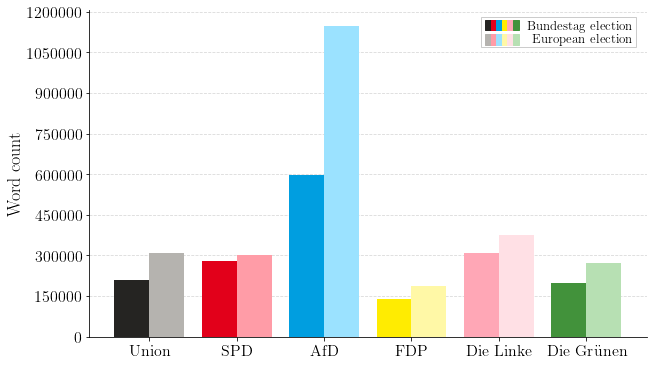

In [41]:
bt_sub_words = pd.Series([len(merge(bt_subs[corpus.party == party])) for party in parties], index=parties.keys())
eu_sub_words = pd.Series([len(merge(eu_subs[corpus.party == party])) for party in parties], index=parties.keys())

fig = plot_compare_bar(bt_sub_words, eu_sub_words, 'Word count')

fig.savefig('outputs/yt-word-count.pdf', bbox_inches = 'tight', pad_inches = 0)

## Topic analysis algorithms
### tf-idf

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer


def distinct(df, n=10):
    """ Takes a pandas matrix, where rows are words and columns parties, 
    and returns the n highest distinct words.
    """
    matrix = df.copy()
    parties = matrix.columns
    entries = {party: [] for party in parties}
    while any(map(lambda key: len(entries[key]) < n, entries)):
        next_party = matrix.max().idxmax()
        word = matrix[next_party].idxmax()
        matrix.drop(word, inplace=True)
        entries[next_party].append(word)
        if len(entries[next_party]) >= n:
            matrix.drop(next_party, axis=1, inplace=True)
    return pd.DataFrame(entries)

def print_distinct_tfidf_table(corp, n=10):
    tfidf = TfidfVectorizer(sublinear_tf=True, 
                             preprocessor=lambda x: x, 
                             tokenizer=lambda x: x,
                             strip_accents='unicode')

    corpora = (merge(corp[corp.index.isin(corpus[corpus.party == party].index)]) for party in parties)
    x = tfidf.fit_transform(corpora)
    df = pd.DataFrame(x.T.toarray(), index=tfidf.get_feature_names(), columns=parties)
    dis = distinct(df, n)
    display_side_by_side(dis[[party]] for party in parties)
    return {party: {word: df.loc[word, party] for word in dis[party]} for party in parties}

#### Whole corpus

#### No long videos (< 20 min) 

In [43]:
pre_bt_short_subs

videoId
-1RoUTaqf6c    [richtig, stehen, heute, her, diät, ehemalig, ...
-2MIMgq-wco    [anbieten, wahrheit, äh, sehen, jemand, planen...
-329N7ism6o    [herr, präsident, kollegin, kollege, anhörung,...
-6_ktY0lYZk    [6579, ausländer, hamburg, ausreisepflichtig, ...
-6daJlk2kfk    [statement, christian, lindner, befinden, radi...
                                     ...                        
zjZ6syp28lw    [moin, name, stefan, riesebeck, ertragen, ding...
zsa13XzeWr0    [präsidentin, lieb, kollegin, kollege, regieru...
zt7h3_XVifw    [dörte, liebetruth, gemeinsam, mensch, landkre...
zxQwFRa_kxQ    [geehrt, präsident, lieb, kollegin, kollege, l...
zysvLXjnAvY    [heute, stehen, eu, schwierig, aufgabe, seit, ...
Name: subtitle, Length: 1431, dtype: object

In [44]:
tfidf_pre_bt_short = print_distinct_tfidf_table(pre_bt_short_subs, 20)
tfidf_pre_eu_short = print_distinct_tfidf_table(pre_eu_short_subs, 20)

,union
0,bayernplan
1,krebsregister
2,geißler
3,unionsfraktion
4,weltkulturerbe
5,begehbar
6,schorndorf
7,gut
8,erzieherausbildung
9,jahr


,union
0,arbeitskammer
1,ausbildungsvorbereitung
2,großregion
3,brok
4,elmar
5,saarländisch
6,land
7,armin
8,thema
9,werden


#### Which video contains that word?

In [45]:
corpus[subtitles.apply(lambda x: '1050' in x)][['party', 'title','subtitle']]

,party,title,subtitle
videoId,,,
-lMRY_sdjGg,linke,"Sabine Zimmermann, DIE LINKE: Vereinbarte Deba...",sehr geehrter herr präsident meine damen und h...
-qX1PI0QIsA,linke,Sahra Wagenknecht in Trier,aber ich bin trotzdem sehr glücklich darüber d...
2DAeGt3Liis,linke,Zentrale Wahlkampfveranstaltung der LINKEN Bay...,zieht es die leute sind da und bisschen länger...
59ZmT1wtkMc,linke,"Katja Kipping zur Bundestagswahl 2017, Dresden...",politik ist nicht freue mich dass so viele gek...
6nAkc03B-e4,linke,Achelwilm: Wahlkampfrede,schönberg andreas für die freundliche anregung...
6pG28At3T_k,linke,Jobcenter-Aktion in Bremen,das steht heute vom jobcenter in bremen müsse ...
A1FGnhRyx8Q,linke,Hartz IV muss weg,frau präsidentin meine damen und herren ich ha...
B656oa-hMRs,linke,Sahra Wagenknecht in Ludwigshafen,werden die chance wenn du mir das doch das ja ...
BfIiDPr3xuM,linke,Wahlkampfrede Bartsch in Bremen,ja einen schönen guten tag liebe bremerinnen u...


#### Word cloud visualization

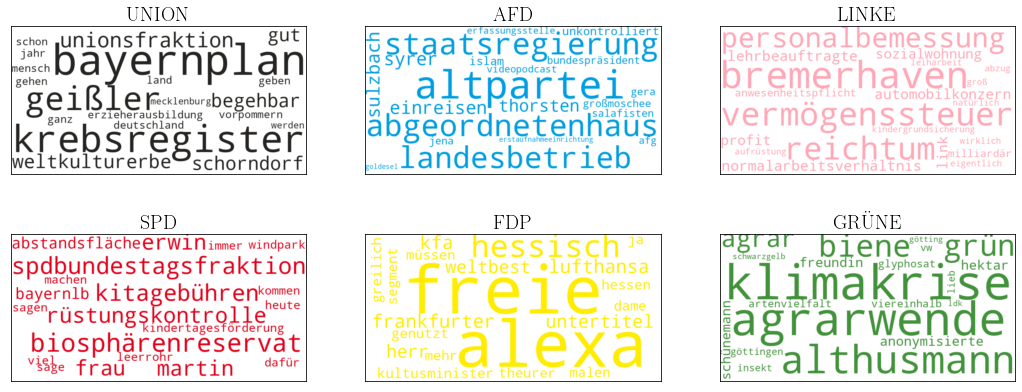

In [46]:
from wordcloud import WordCloud

fig = generate_wordcloud(tfidf_pre_bt_short, "TF-IDF - 2016 Bundestag election - YouTube corpus")
fig.savefig('outputs/yt-tfidf-wordcloud-bt.pdf', bbox_inches = 'tight', pad_inches = 0)

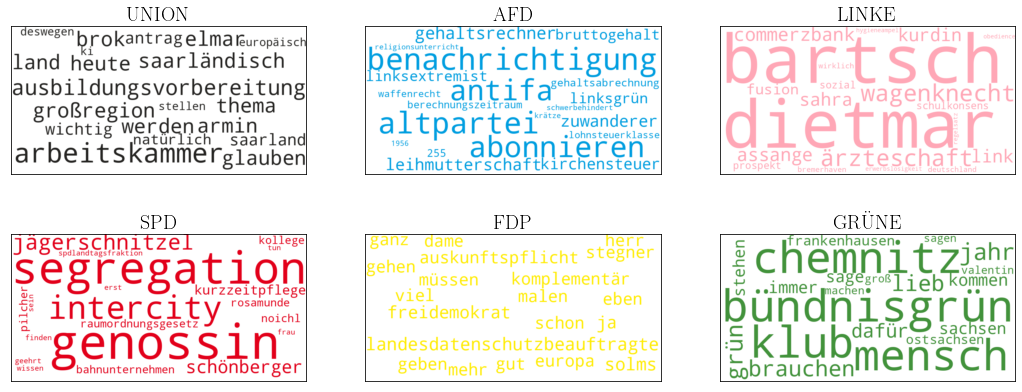

In [50]:
fig = generate_wordcloud(tfidf_pre_eu_short, "TF-IDF - 2019 European election - YouTube corpus")
fig.savefig('outputs/yt-tfidf-wordcloud-eu.pdf', bbox_inches = 'tight', pad_inches = 0)

## LDA

In [48]:
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.evaluate import results_by_parameter

### Tag based

In [49]:
climate_tags = ['klimaschutz']
refugee_tags = ['flüchtlinge']
economy_tags = ['artikel 13']

def get_videos_with_certain_tags(tags):
    return corpus['tags'].apply(lambda vtags: any([t in list(map(str.lower, vtags)) for t in tags]))

climate_ids = get_videos_with_certain_tags(climate_tags)
refugee_ids = get_videos_with_certain_tags(refugee_tags)
economy_ids = get_videos_with_certain_tags(economy_tags)

tag_corpus = subtitles[climate_ids | refugee_ids | economy_ids]
print("Climate: ", sum(climate_ids), " Refugee: ", sum(refugee_ids), " Economy: ", sum(economy_ids))

Climate:  118  Refugee:  50  Economy:  21


### Temp

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from gensim import corpora, models

def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
        
def doLDA_sk(corp):
    v = TfidfVectorizer(sublinear_tf=True, 
                             preprocessor=lambda x: x, 
                             tokenizer=lambda x: x,
                             strip_accents='unicode')
    tfidf = v.fit_transform(corp[:100])
    lda_tfidf = LDA(n_components=100, random_state=0, n_jobs=-1, learning_method='online')
    lda_tfidf.fit(tfidf)
    print_topics(lda_tfidf, v, 10)
    return (lda_tfidf,tfidf,v)

def doLDA_gen(bag_of_words):
    dictionary = corpora.Dictionary(bag_of_words)
    corp = [dictionary.doc2bow(text) for text in bag_of_words]
    lda = models.ldamodel.LdaModel(corpus=corp, id2word=dictionary, num_topics=10, update_every=1, chunksize =10000, passes=100)
    return (lda, corp, dictionary)

def print_topics_gen(lda_model, count_vectorizer, num_words=20):
    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words):
        print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))


### Prepare dataset

In [53]:
import gensim

bt_bag_of_words = subtitles[bt_period & (corpus.duration <= 60*10)]
eu_bag_of_words = subtitles[eu_period & (corpus.duration <= 60*10)]

bt_dictionary = gensim.corpora.Dictionary(bt_bag_of_words)
eu_dictionary = gensim.corpora.Dictionary(eu_bag_of_words)

bt_corp = [bt_dictionary.doc2bow(text) for text in bt_bag_of_words]
eu_corp = [eu_dictionary.doc2bow(text) for text in eu_bag_of_words]

#### Determine number of topics

In [58]:
import gensim
from gensim.models import CoherenceModel

mallet_path = '/home/rattletat/mallet/bin/mallet' 

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, update_every=1, chunksize =10000, passes=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("Status: ", num_topics)

    return model_list, coherence_values

In [59]:
# Can take a long time to run.
bt_model_list, bt_coherence_values = compute_coherence_values(dictionary=bt_dictionary, corpus=bt_corp, texts=bt_bag_of_words, start=10, limit=250, step=20)
eu_model_list, eu_coherence_values = compute_coherence_values(dictionary=eu_dictionary, corpus=eu_corp, texts=eu_bag_of_words, start=10, limit=250, step=20)

Status:  10
Status:  30
Status:  50


KeyboardInterrupt: 

In [ ]:
# Show graph
start=10; limit=400; step=30;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.grid()
#plt.legend("coherence_values", loc='best')
plt.savefig('outputs/number_of_topics-youtube.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Calculate LDA model

In [62]:
#model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corp, num_topics=250, id2word=dictionary)
bt_model = gensim.models.ldamodel.LdaModel(corpus=bt_corp, id2word=bt_dictionary, num_topics=65, update_every=1, chunksize =10000, passes=30)
eu_model = gensim.models.ldamodel.LdaModel(corpus=bt_corp, id2word=eu_dictionary, num_topics=65, update_every=1, chunksize =10000, passes=30)

#### Print topics

In [63]:
def print_topics_gen(lda_model, count_vectorizer, num_words=20):
    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words, num_topics=-1):
        print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

In [68]:
print_topics_gen(bt_model, bt_dictionary)

Topic: 0 
Words: geben|herr|ganz|antrag|mehr|neu|ja|dame|gehen|gut|natürlich|land|jahr|malen|fraktion|lassen|schon|kind|müssen|genau
Topic: 1 
Words: geben|jahr|malen|rechtsanwalt|gehen|gut|müssen|neu|sagen|afghanistan|machen|mehr|land|versorgungswerk|landwirtschaft|frage|ja|erst|ergebnis|problem
Topic: 2 
Words: glyphosat|landwirtschaft|pestizid|verbieten|landwirt|wirkstoff|pflanzenschutzmittel|insekt|einsatz|kommen|jahr|schmidt|lebensmittel|krebserregend|herr|deutsch|risiko|ökologisch|frau|wenig
Topic: 3 
Words: ja|herr|frau|geben|werden|gehen|antrag|mehr|kommen|land|malen|dame|machen|schon|eben|fragen|viel|sagen|gut|jahr
Topic: 4 
Words: herr|dame|niedersachsen|müssen|mehr|land|gut|partei|viel|ministerpräsident|grün|rot|minister|gehen|wahlkreis|werden|kind|spd|schon|mögen
Topic: 5 
Words: gehen|malen|kollege|herr|ja|mehr|geehrt|ganz|jahr|gerade|werden|geben|dame|hören|schon|kollegin|siemens|mögen|sagen|fragen
Topic: 6 
Words: jahr|15|land|europäisch|eu|herr|deutschland|führerschein|

#### Create topic classes

In [69]:
environmental_words = ['klima', 'tierhaltung', 'ökologisch', 'nachhaltig', 'erneuerbar']
refugee_words = ['flüchtling', 'asyl', 'einwanderung', 'migrant', 'zuwanderung']

environmetal_topics = set()
refugee_topics = set()

for idx, topic in bt_model.show_topics(formatted=False, num_words=10, num_topics=-1):
    for w in topic:
        if any(w[0] in env or env in w[0] for env in environmental_words):
            environmetal_topics.add(idx)
        if any(w[0] in ref or ref in w[0] for ref in refugee_words):
            refugee_topics.add(idx)        
            
distinct_environmental_topics = environmetal_topics - refugee_topics
distinct_refugee_topics = refugee_topics - environmetal_topics


print("Distinct environmental topics of length: ", len(distinct_environmental_topics))
print(distinct_environmental_topics)
print("Distinct refugee topics of length: ", len(distinct_refugee_topics))
print(distinct_refugee_topics)

Distinct environmental topics of length:  12
{0, 1, 34, 36, 37, 6, 45, 46, 50, 23, 27, 61}
Distinct refugee topics of length:  1
{30}


In [75]:
def format_topics_sentences(ldamodel, corpus, texts=bt_short_subs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=bt_model, corpus=bt_corp)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Party'] = corpus.reindex(bt_short_subs.reindex(df_dominant_topic['Document_No']).index)['party']
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Party
0,0,12.0,0.9754,"ja, frau, herr, malen, geben, ganz, gut, dame,...",NaN,NaN
1,1,41.0,0.9344,"ja, malen, herr, geben, ganz, sagen, link, ant...",NaN,NaN
2,2,16.0,0.9980,"ja, antrag, malen, herr, schon, geben, mehr, k...",NaN,NaN
3,3,16.0,0.4691,"ja, antrag, malen, herr, schon, geben, mehr, k...",NaN,NaN
4,4,51.0,0.9397,"mensch, gut, grün, gehen, jahr, müssen, ganz, ...",NaN,NaN
5,5,11.0,0.4495,"herr, ja, dame, geben, müssen, mehr, viel, sag...",NaN,NaN
6,6,17.0,0.4108,"ja, malen, sage, ganz, geben, gehen, müssen, s...",NaN,NaN
7,7,10.0,0.9734,"bafög, studierend, müssen, landesrechnungshof,...",NaN,NaN
8,8,19.0,0.9344,"hochschule, universität, studierend, müssen, f...",NaN,NaN
9,9,51.0,0.3106,"mensch, gut, grün, gehen, jahr, müssen, ganz, ...",NaN,NaN


#### Class topics

In [ ]:
import pyLDAvis

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, tfidf, v)